## Spark streaming

Dans les tutoriels précédents nous avons toujours travaillé avec des données statiques sous forme d'import/export.
Voyons ici un premier exemple de données qui évoluent.
Pour ce faire, nous vous proposons de streamer les tweets de l'insee avec spark streaming.

L'idée derrière la notion de streaming est celle du flot continu de données dont les méthodes d'analyse par batch ne répondent pas aux enjeux de vélocité. Dans la statistique publique le besoin est faible pour le moment.  

Pour être précis il y a trois notions :
* batch processing 
* micro batch processing ( flot traité comme des batchs de très courte durée comme une seconde)
* stream processing ( chaque ligne est un évenement et déclenchera une réaction dans le SI, developpement évenementiel )

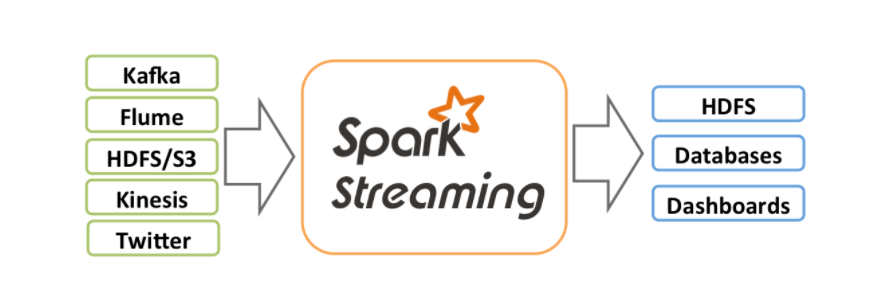

Dans notre cas avec spark nous sommes plutôt sur du micro-batch

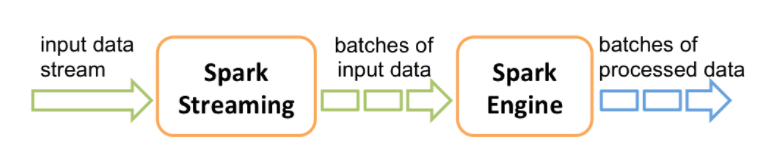

### Pré-requis

#### La source de donnée

Un petit programme est executé sur le datalab afin de streamer **les tweets contenant insee ou inseeFr**.
En général les données proviennent d'un broker de message comme kafka mais pour simplifier le tutoriel ces tweets sont écrits sous la forme de petits fichiers au fil de l'eau dans le bucket suivant :
* **s3a://projet-spark-lab/diffusion/tweets**

Regardons le contenu de ce répertoire avec la commande hadoop en prenant les 2 fichiers les plus récents

In [1]:
!hadoop fs -ls -t   "s3a://projet-spark-lab/diffusion/tweets/input" | grep "tweets"| head -n2

2021-04-15 15:07:45,553 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2021-04-15 15:07:45,619 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2021-04-15 15:07:45,619 INFO impl.MetricsSystemImpl: s3a-file-system metrics system started
drwxrwxrwx   - jovyan jovyan          0 2021-04-15 15:07 s3a://projet-spark-lab/diffusion/tweets/input/2021
-rw-rw-rw-   1 jovyan jovyan       2750 2021-04-15 15:06 s3a://projet-spark-lab/diffusion/tweets/input/2021-04-15-15-06-35
grep: write error: Broken pipe
2021-04-15 15:07:47,608 INFO impl.MetricsSystemImpl: Stopping s3a-file-system metrics system...
2021-04-15 15:07:47,608 INFO impl.MetricsSystemImpl: s3a-file-system metrics system stopped.
2021-04-15 15:07:47,608 INFO impl.MetricsSystemImpl: s3a-file-system metrics system shutdown complete.


Vous pouvez voir le contenu d'un fichier en executant cette commande laissée en exemple (affichage un peu long).

```
!hadoop fs -ls -r -t "s3a://projet-spark-lab/diffusion/tweets/input" | head -n2 |awk '{print $8}' | xargs -I{} hadoop fs -cat {} | head -n1
```
Les fichiers contiennent des tweets au format json de l'api twitter.

#### Le schéma de la donnée

Pour simplifier le schema de la donnée a été mis ici au format pickle à côté du notebook dans 7-streaming/schema.p





### Spark streaming

Historiquement, spark proposait spark streaming il propose aujourd'hui spark streaming et spark structured streaming qui vient répondre aux uses cases les plus standards avec des données structurées (avec un schéma).

On peut avoir majoritairement les sources suivantes :
* Plutot pour du test, il existe le type **rate** pour générer de fausses données (timestamp, long) et **tcp** pour récupérer des données envoyées via une socket tcp
* Plutot dans la vraie vie, il existe le type **fichier** pour scruter un répertoire et lire les fichiers ou le type **kafka** pour lire des topics de cette solution de broker de message.

Quoique les avantages de kafka pourraient être discutés dans un futur tutoriel, pour simplifier la mise à disposition de celui-ci nous allons donc nous baser sur les données présentes dans le bucket **"s3a://projet-spark-lab/diffusion/tweets/input"**

Nous allons essayer de faire le streaming suivant:
* Streamer les données et avoir les hashtags les plus présents dans les tweets concernant l'Insee dans les 3 dernières heures glissantes.

Nous allons par souci de simplification et pour ne pas persister des données en écriture via ce tuto enregistre le résultat de ce streaming dans une table en mémoire.

Nous pourrions faire sur les tweets d'autres manipulations, charge à chacun d'être inventif:
* Faire des stats sur les retweets, sur les mentions @User les plus présents, sur les comptes, sur les médias mentionnant l'insee....


### Déclaration du context spark (c'est toujours ou presque la même chanson)


In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import os

conf = SparkConf()

#url par défaut d'une api kubernetes accédé depuis l'intérieur du cluster (ici le notebook tourne lui même dans kubernetes)
conf.setMaster("k8s://https://kubernetes.default.svc:443")

#image des executors spark: pour des raisons de simplicité on réutilise l'image du notebook
conf.set("spark.kubernetes.container.image", "inseefrlab/jupyter-datascience:master")

# Nom du compte de service pour contacter l'api kubernetes : attention le package du datalab crée lui même cette variable d'enviromment.
# Dans un pod du cluster kubernetes il faut lire le fichier /var/run/secrets/kubernetes.io/serviceaccount/token
# Néanmoins ce paramètre est inutile car le contexte kubernetes local de ce notebook est préconfiguré
# conf.set("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT']) 

# Nom du namespace kubernetes
conf.set("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])

# Nombre d'executeur spark, il se lancera autant de pods kubernetes que le nombre indiqué.
conf.set("spark.executor.instances", "5")

# Mémoire alloué à la JVM
# Attention par défaut le pod kubernetes aura une limite supérieur qui dépend d'autres paramètres.
# On manipulera plus bas pour vérifier la limite de mémoire totale d'un executeur
conf.set("spark.executor.memory", "4g")

conf.set("spark.kubernetes.driver.pod.name", os.environ['KUBERNETES_POD_NAME'])

# Paramètres d'enregistrement des logs spark d'application
# Attention ce paramètres nécessitent la création d'un dossier spark-history. Spark ne le fait pas lui même pour des raisons obscurs
# import s3fs
# endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
# fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})
# fs.touch('s3://tm8enk/spark-history/.keep')
# sparkconf.set("spark.eventLog.enabled","true")
# sparkconf.set("spark.eventLog.dir","s3a://tm8enk/spark-history")
#ici pour gérer le dateTimeFormatter dépendant de la verion de java...
conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
#conf.set("spark.sql.session.timeZone", "UTC")

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("streaming").config(conf = conf).getOrCreate()

#### Lancons la définition de ce que l'on veut streamer

Plusieurs options sont disponibles, nous les laissons avec les valeurs par défaut :
* .option("latestFirst","false")  lire le fichier avec la date de modification la plus récente en premier ou non
* .option("maxFileAge","1 week")  l'age maximum du fichier
* .option("maxFilesPerTrigger","no max") nombre maximum de fichier par execution de stream
* .option("cleanSource","off") action à faire sur les fichiers lus (off :rien, archived:déplacer, delete:supprimer)

In [3]:
import pickle
schema = pickle.load( open( "./7-streaming/schema.p", "rb" ) )

In [4]:
df = spark.readStream.format("json")  \
    .schema(schema) \
    .option("latestFirst","true") \
    .load("s3a://projet-spark-lab/diffusion/tweets/input") \

Lors de la définition de ce que l'on streame, rien ne se passe c'est toujours le côté lazy de spark tant qu'aucune action sur ce streame n'a été définie et tant que la méthode start() n'a pas été executée sur le stream rien ne passe

### Création de la table in memory sur les hashtags

On doit définir ici la transformation à appliquer, on vous commente le schéma de l'objet tweet un peu long mais le contenu du tweet se trouve dans la colonne text on se base sur spark-sql pour manipuler l'objet df qui est du type Dataframe.

Ici on lui demande d'ajouter la colonne word en splittant le contenu du tweet par l'espace puis cette liste de mot d'en faire une colonne de mot de filtrer ceux commencant par #  et ensuite de faire un group by.

Pour cela on utilise les pyspark.sql.functions

In [5]:
#df.printSchema()

In [6]:
from pyspark.sql.functions import explode,split
from pyspark.sql.functions import col

tweets_tab = df.withColumn('word', explode(split(col('text'), ' '))) \
    .filter(col('word').contains('#')) \
    .groupBy('word') \
    .count() \
    .sort('count', ascending=False)


### Maintenant il faut lui dire sous quelle forme maintenir cette transformation

Il existe plusieurs output retenons celles-ci :
* une table parquet que vous connaissez maintenant (qu'on pourra donc décrire dans hive et ensuite par redash!)
* console (écrire le résultat dans la console)
* memory (consolider une table sql en mémoire du cluster)

Il existe aussi plusieurs mode d'output: https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#output-modes
* complete (a chaque itération de stream redonne tout le resultat)
* append (a chaque itération de stream ne donne que les nouvelles lignes)
* update (seulement les lignes qui ont changées)

Ci-dessous nous lui demandons de faire un streame en prenant les nouveaux fichiers tous les 10 seconds et de mettre le résultat complet en mémoire.

In [7]:
tweets_tab.writeStream. \
    outputMode("complete"). \
    format("memory"). \
    queryName("tweetquery_group_hashtag"). \
    trigger(processingTime='10 seconds'). \
    start()

C'est parti le streaming a démarré voyons ca dans la spark-ui, on a un nouvel onglet streaming avec la liste des streams actifs

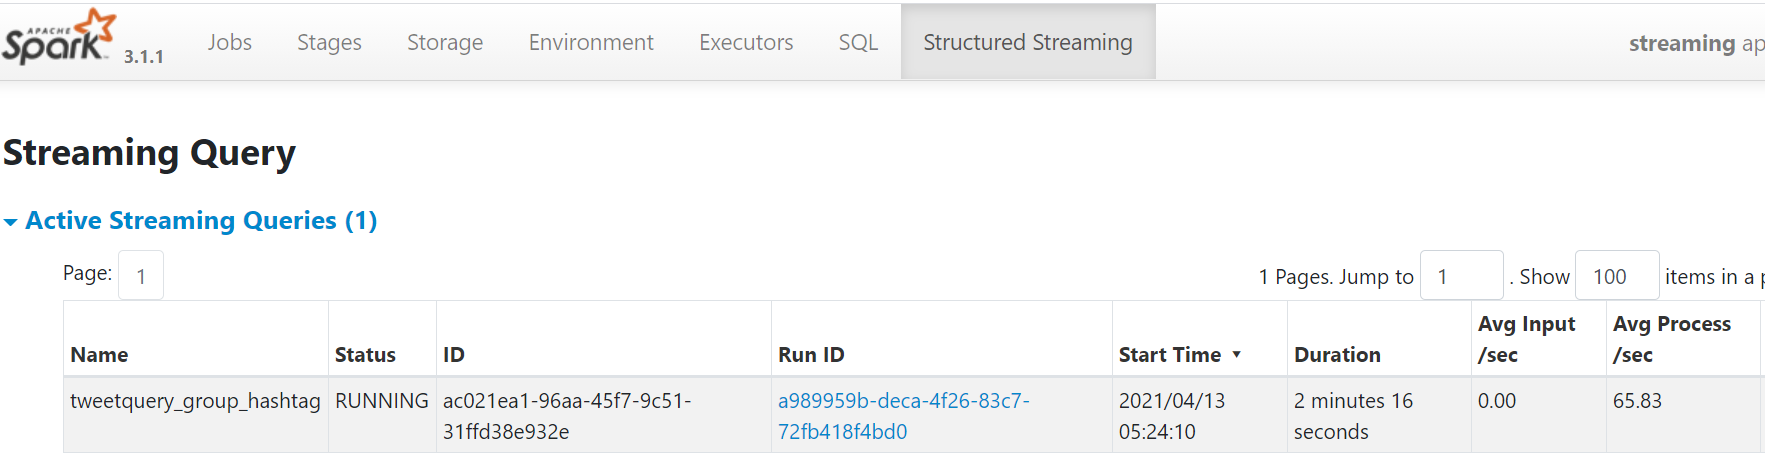

On peut cliquer dessus y avoir le débit, le temps d'execution et autres métriques.

On peut via l'api récupérer les streams en cours et les arreter, si vous faites start sur un stream déjà en cours, il va pas apprécier il faut auparavant l'arréter.

In [8]:
#for stream in spark.streams.active:
#    print("streaming", stream.name, "avec l'id", stream.id, "en cours")
#    spark.streams.get(stream.id).stop()


### Requetons cette table

Le fait de l'avoir déclaré in memory au nom de "tweetquery_group_hashtag" nous permet de la requeter ou de l'exhiber via le spark thrift server (voir autre tutoriel).

Il est préférable d'attendre quelques secondes avant d'executer cette celle le temps que le streaming se lance, liste les fichiers s3 et execute les traitements.

In [9]:
spark.sql("select * from tweetquery_group_hashtag  order by count desc limit 10").show()

+----+-----+
|word|count|
+----+-----+
+----+-----+



### Watermark

**Ok mais n'avions pas dit que nous voulions ce hastag sur les derners 24h de tweets?**

Ici, spark streame et conserve toutes les données streamées,l'output mode complet lui fait remettre toutes les données. Aussi nous préférions avoir les données sur 3h par exemple glissant par fenetre de 5 minutes.

Les tweets contiennent une colonne date created_at. **{"created_at":"Thu Apr 08 15:43:36 +0000 2021"**

Nous pourrions importe les fonctions pyspark.sql.functions mais on peut aussi avec selectExpr directement les utiliser ainsi :
* on transforme la date en timestamp dans le fuseau horaire de Paris 
* on demande a spark de gérer un watermark  sur 3 heures par rapport à la colonne timestamp (a lui de supprimer les tweets dépassant ce seuil donc.
* on lui demande de faire un groupe by word count en gardant une fenetre de 5 minutes

In [10]:
from pyspark.sql.functions import window, col,from_utc_timestamp,to_timestamp,explode, split

tweets_tab_24=df \
    .withColumn("timestamp",to_timestamp('created_at', 'EEE MMM d HH:mm:ss Z yyyy')) \
    .withColumn("word",explode(split("text",' '))) \
    .filter(col("word").contains('#')) \
    .withWatermark("timestamp", "1 minute") \
    .groupBy(
        window("timestamp", "3 hours","5 minutes"),
        "word") \
    .count()

Code test qui a servi à trouver le bon pattern
```
from pyspark.sql import Row
from pyspark.sql.functions import from_unixtime, unix_timestamp, from_utc_timestamp, min, max
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
rdd  = spark.sparkContext.parallelize([u'Thu Apr 08 15:43:36 +0000 2021'])
row = Row("ts")
df = rdd.map(row).toDF()
df.show()

df.withColumn("ts", from_utc_timestamp(to_timestamp("ts", "EEE MMM d HH:mm:ss Z yyyy"),"Europe/Paris")).show()
```

On fait idem que précédent pour mettre in memory le résultat mais le mode ne peut pas etre complet en watermark puisqu'on veut delete au fur et a mesure.

In [11]:
tweets_tab_24.writeStream.outputMode("append").trigger(processingTime='1 minute').format("memory").queryName("data").start() 


In [18]:
from IPython.display import display, clear_output
from datetime import datetime

spark.sql('select * from data').show(10,False)

+------+----+-----+
|window|word|count|
+------+----+-----+
+------+----+-----+



Ici Spark entretien en mémoire un dataframe de 3 colonnes :
* intervalle de temps de 5 minutes window.start-window.end
* mot
* nombre d'occurence du mot

Ce dataframe ne contient que les intervalles de temps des 5 dernières minutes des 3 dernières heures, les intervalles plus ancien sont supprimés.
Si un tweet arrive par hasard avec un timestamp plus vieux que 3h le watermark l'élimine aussi des aggrégats.

En mode append, on obtient pour chaque execution de batch les nouvelles lignes que l'on peut ensuite persistées via un DataFrameWriter ou Synk.
Par example un FileSynk pour écrire sur S3, jdbcSynk ou CassandraSynk.

Pour le tutoriel on utilise le MemorySynk qui renseigne donc une table en mémoire qui grossit de chaque append au fur et à mesure du temps.

In [18]:
from IPython.display import display, clear_output
from datetime import datetime
import time

for i in range(6):
    clear_output(wait=True)
    print("A", datetime.now(), "le top 20 des hastags sur les tweets mentionnait l'insee dans les 3 dernières heures est :")
    display(spark.sql("select * from data where window.start > current_timestamp()-INTERVAL 200 minutes order by word desc" ).show())
    time.sleep(30)

A 2021-04-15 16:13:22.900447 le top 20 des hastags sur les tweets mentionnait l'insee dans les 3 dernières heures est :
+--------------------+--------------------+-----+
|              window|                word|count|
+--------------------+--------------------+-----+
|{2021-04-15 13:05...|           L’#emploi|    1|
|{2021-04-15 13:00...|           L’#emploi|    1|
|{2021-04-15 12:55...|           L’#emploi|    1|
|{2021-04-15 12:55...|    #ÉclairerLeDébat|    1|
|{2021-04-15 13:00...|    #ÉclairerLeDébat|    1|
|{2021-04-15 13:05...|    #ÉclairerLeDébat|    1|
|{2021-04-15 12:55...|           #quizzBMD|    2|
|{2021-04-15 13:00...|           #quizzBMD|    1|
|{2021-04-15 12:55...|#pensionalimentai...|    1|
|{2021-04-15 13:05...|#pensionalimentai...|    1|
|{2021-04-15 13:00...|#pensionalimentai...|    1|
|{2021-04-15 12:55...|             #loyers|    4|
|{2021-04-15 13:00...|             #loyers|    4|
|{2021-04-15 13:05...|             #loyers|    4|
|{2021-04-15 12:55...|        

None

In [ ]:
spark.stop()